In [1]:
import numpy as np
import cv2, os, pyautogui, time
from PIL import Image
import matplotlib.pyplot as plt
import warnings

from src.face_features import *
from src.tools import *

width, height= pyautogui.size()

In [22]:
from src.model import model
from keras.layers import *
from keras.models import Model
from keras.layers.advanced_activations import LeakyReLU
from src.config import *

import numpy as np

# CNN structure for eyes
conv1_eye_size = 5
conv1_eye_out = 128
conv1_eye_strides = 2
pool1_eye_size = 2
pool1_eye_stride = 2

conv2_eye_size = 3
conv2_eye_out = 64
conv2_eye_strides = 2
pool2_eye_size = 2
pool2_eye_stride = 2

# CNN structure for face
conv1_face_size = 9
conv1_face_out = 256
conv1_face_strides = 1
pool1_face_size = 2
pool1_face_stride = 2

conv2_face_size = 5
conv2_face_out = 64
conv2_face_strides = 2
pool2_face_size = 2
pool2_face_stride = 2

conv3_face_size = 3
conv3_face_out = 64
pool3_face_size = 2
pool3_face_stride = 2

# CNN structure for mask
conv1_mask_size = 7
conv1_mask_out = 32
conv1_mask_strides = 2
pool1_mask_size = 2
pool1_mask_stride = 2

conv2_mask_size = 5
conv2_mask_out = 32
conv2_mask_strides = 1
pool2_mask_size = 2
pool2_mask_stride = 2

conv3_mask_size = 3
conv3_mask_out = 32
pool3_mask_size = 2
pool3_mask_stride = 2

fc_eye_size = 128
fc_face_size = 128
fc2_face_size = 128
fc_mask_size = 128
fc_size = 128
fc2_size = 2

right_input = Input(shape=(eye_size[1], eye_size[0], n_channel))
left_input = Input(shape=(eye_size[1], eye_size[0], n_channel))
face_input = Input(shape=(face_size[1], face_size[0], n_channel))
mask_input = Input(shape=(mask_size[1], mask_size[0], n_channel))

conv1_right = Conv2D(conv1_eye_out, kernel_size=conv1_eye_size, strides=conv1_eye_strides)(right_input)
conv1_pool_right = MaxPooling2D(pool_size=pool1_eye_size, strides=pool1_eye_stride)(conv1_right)
conv2_right = Conv2D(conv2_eye_out, kernel_size=conv2_eye_size, strides=conv2_eye_strides)(conv1_pool_right)
conv2_pool_right = MaxPooling2D(pool_size=pool2_eye_size, strides=pool2_eye_stride)(conv2_right)

conv1_left = Conv2D(conv1_eye_out, kernel_size=conv1_eye_size, strides=conv1_eye_strides)(left_input)
conv1_pool_left = MaxPooling2D(pool_size=pool1_eye_size, strides=pool1_eye_stride)(conv1_left)
conv2_left = Conv2D(conv2_eye_out, kernel_size=conv2_eye_size, strides=conv2_eye_strides)(conv1_pool_left)
conv2_pool_left = MaxPooling2D(pool_size=pool2_eye_size, strides=pool2_eye_stride)(conv2_left)

conv1_face = Conv2D(conv1_face_out, kernel_size=conv1_face_size, strides=conv1_face_strides)(face_input)
conv1_pool_face = MaxPooling2D(pool_size=pool1_face_size, strides=pool1_face_stride)(conv1_face)
conv2_face = Conv2D(conv2_face_out, kernel_size=conv2_eye_size, strides=conv2_face_strides)(conv1_pool_face)
conv2_pool_face = MaxPooling2D(pool_size=pool2_face_size, strides=pool2_face_stride)(conv2_face)
conv3_face = Conv2D(conv3_face_out, kernel_size=conv3_face_size)(conv2_pool_face)
conv3_pool_face = MaxPooling2D(pool_size=pool3_face_size, strides=pool3_face_stride)(conv3_face)

conv1_mask = Conv2D(conv1_mask_out, kernel_size=conv1_mask_size, strides=conv1_mask_strides)(mask_input)
conv1_pool_mask = MaxPooling2D(pool_size=pool1_mask_size, strides=pool1_mask_stride)(conv1_mask)
conv2_mask = Conv2D(conv2_mask_out, kernel_size=conv2_mask_size, strides=conv2_mask_strides)(conv1_pool_mask)
conv2_pool_mask = MaxPooling2D(pool_size=pool2_mask_size, strides=pool2_mask_stride)(conv2_mask)
conv3_mask = Conv2D(conv3_mask_out, kernel_size=conv3_mask_size)(conv2_pool_mask)
conv3_pool_mask = MaxPooling2D(pool_size=pool3_mask_size, strides=pool3_mask_stride)(conv3_mask)

right_out = Reshape([-1, int(np.prod(conv2_pool_right.get_shape()[1:]))])(conv2_pool_right)
left_out = Reshape([-1, int(np.prod(conv2_pool_left.get_shape()[1:]))])(conv2_pool_left)

eyes = Concatenate(axis=-1)([right_out, left_out])
eyes = Dense(fc_eye_size, activation="relu")(eyes)
eyes = Flatten()(eyes)

face = Reshape([-1, int(np.prod(conv3_pool_face.get_shape()[1:]))])(conv3_pool_face)
face = Dense(fc_face_size, activation="relu")(face)
face = Dense(fc2_face_size, activation="relu")(face)
face = Flatten()(face)

mask = Reshape([-1, int(np.prod(conv3_pool_mask.get_shape()[1:]))])(conv3_pool_mask)
mask = Dense(fc_mask_size, activation="relu")(mask)
mask = Flatten()(mask)

fc = Concatenate(axis=-1)([eyes, face, mask])
fc2 = Dense(fc_size, activation="relu")(fc)
fc2 = Dropout(0.5)(fc2)
fc2 = Dense(fc_size, activation="relu")(fc2)
out = Dense(fc2_size, activation="sigmoid")(fc2)

model = Model([left_input, right_input, face_input, mask_input], out)
model.compile(optimizer='adam', loss="mse")
model.summary() 

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_64 (Conv2D)              (None, 56, 56, 256)  20992       input_27[0][0]                   
__________________________________________________________________________________________________
input_28 (InputLayer)           [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
input_25 (InputLayer)           [(None, 32, 64, 1)]  0                                            
______________________________________________________________________________________

In [9]:
# pickle.dump([X_left, X_right, X_face, X_mask, Y], open("save.pkl", "wb"))

# X_left = np.concatenate([X_left, X_left_old])
# X_right = np.concatenate([X_right, X_right_old])
# X_face = np.concatenate([X_face, X_face_old])
# X_mask = np.concatenate([X_mask, X_mask_old])
# Y = np.concatenate([Y, Y_old])

In [7]:
X_left_old, X_right_old, X_face_old, X_mask_old, Y_old = X_left, X_right, X_face, X_mask, Y

In [10]:
import pickle

[X_left, X_right, X_face, X_mask, Y] = pickle.load(open("save.pkl", "rb"))
print(X_left.shape, X_right.shape, X_face.shape, X_mask.shape, Y.shape)

(16292, 32, 64, 1) (16292, 32, 64, 1) (16292, 64, 64, 1) (16292, 64, 64, 1) (16292, 2)


In [14]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(list(range(len(Y))), train_size=0.9, shuffle=True)

X_train = [X_left[train_set], X_right[train_set], X_face[train_set], X_mask[train_set]]
X_test = [X_left[test_set], X_right[test_set], X_face[test_set], X_mask[test_set]]

In [2]:
from keras.models import load_model
model = load_model("checkpoints")

In [ ]:
history = model.fit(X_train, np.array(Y)[train_set], batch_size=256, epochs=200, validation_data=(X_test, np.array(Y)[test_set]))

Epoch 1/200
58/58 [==============================] - 13s 221ms/step - loss: 0.0576 - val_loss: 0.0432
Epoch 2/200
58/58 [==============================] - 13s 230ms/step - loss: 0.0332 - val_loss: 0.0210
Epoch 3/200
58/58 [==============================] - 12s 206ms/step - loss: 0.0208 - val_loss: 0.0151
Epoch 4/200
58/58 [==============================] - 12s 208ms/step - loss: 0.0155 - val_loss: 0.0121
Epoch 5/200
58/58 [==============================] - 11s 196ms/step - loss: 0.0129 - val_loss: 0.0115
Epoch 6/200
58/58 [==============================] - 12s 208ms/step - loss: 0.0110 - val_loss: 0.0099
Epoch 7/200
58/58 [==============================] - 13s 218ms/step - loss: 0.0098 - val_loss: 0.0098
Epoch 8/200
58/58 [==============================] - 12s 207ms/step - loss: 0.0091 - val_loss: 0.0089
Epoch 9/200
58/58 [==============================] - 13s 217ms/step - loss: 0.0082 - val_loss: 0.0087
Epoch 10/200
58/58 [==============================] - 12s 210ms/step - loss: 0.007

Epoch 81/200
58/58 [==============================] - 9s 161ms/step - loss: 0.0013 - val_loss: 0.0095
Epoch 82/200
58/58 [==============================] - 9s 159ms/step - loss: 0.0015 - val_loss: 0.0093
Epoch 83/200
58/58 [==============================] - 10s 173ms/step - loss: 0.0014 - val_loss: 0.0088
Epoch 84/200
58/58 [==============================] - 8s 145ms/step - loss: 0.0010 - val_loss: 0.0088
Epoch 85/200
58/58 [==============================] - 9s 148ms/step - loss: 9.2475e-04 - val_loss: 0.0085
Epoch 86/200
58/58 [==============================] - 9s 160ms/step - loss: 8.8457e-04 - val_loss: 0.0086
Epoch 87/200
58/58 [==============================] - 8s 141ms/step - loss: 0.0014 - val_loss: 0.0092
Epoch 88/200
58/58 [==============================] - 9s 154ms/step - loss: 0.0011 - val_loss: 0.0096
Epoch 89/200
58/58 [==============================] - 9s 158ms/step - loss: 9.9361e-04 - val_loss: 0.0088
Epoch 90/200
58/58 [==============================] - 10s 171ms/step 

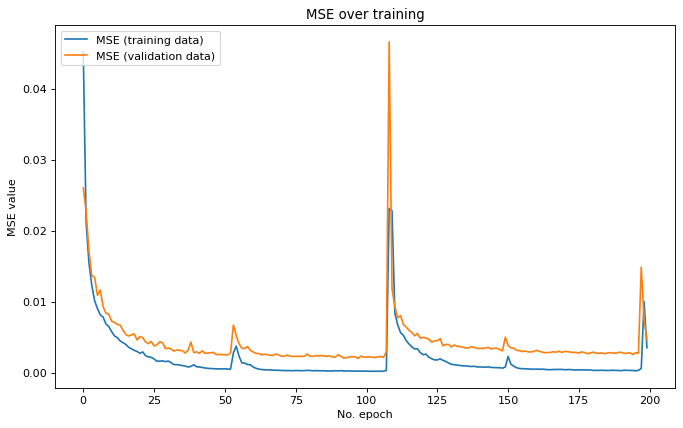

In [16]:
# Plot history: MAE
plt.figure(figsize=(10,6), dpi=80)
plt.plot(history.history['loss'], label='MSE (training data)')
plt.plot(history.history['val_loss'], label='MSE (validation data)')
plt.title('MSE over training')
plt.ylabel('MSE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [31]:
model.predict(X_train)

array([[0.48540208, 0.7891798 ],
       [0.8635393 , 0.48561186],
       [0.97234714, 0.96777076],
       ...,
       [0.49780232, 0.23501046],
       [0.3897495 , 0.62804484],
       [0.693358  , 0.48108467]], dtype=float32)

In [32]:
model.save("checkpoints")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets


# Model pruning

In [38]:
import tempfile
import tensorflow as tf
baseline_model_accuracy = model.evaluate(X_test, np.array(Y)[test_set], verbose=0)

print('Baseline test mse:', baseline_model_accuracy)

_, keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model, keras_file, include_optimizer=False)
print('Saved baseline model to:', keras_file)

Baseline test mse: 0.0001945664407685399
Saved baseline model to: C:\Users\tangji\AppData\Local\Temp\tmpwte_it5j.h5


In [ ]:
import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 256
epochs = 2
validation_split = 0.1 # 10% of training set will be used for validation set. 

num_images = len(X_train)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}

model_for_pruning = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss="mse")

model_for_pruning.summary()

In [44]:
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
#   tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

model_for_pruning.fit(X_train, np.array(Y)[train_set],
                  batch_size=batch_size, epochs=epochs, validation_split=validation_split,
                  callbacks=callbacks)

Epoch 1/2
35/35 [==============================] - 7s 197ms/step - loss: 0.0020 - val_loss: 8.2082e-04
Epoch 2/2
35/35 [==============================] - 6s 165ms/step - loss: 5.5117e-04 - val_loss: 5.0256e-04


In [46]:
model_for_pruning_accuracy = model_for_pruning.evaluate(X_test, np.array(Y)[test_set], verbose=0)

print('Baseline test mse:', baseline_model_accuracy) 
print('Pruned test mse:', model_for_pruning_accuracy)

Baseline test accuracy: 0.0001945664407685399
Pruned test accuracy: 0.0006044685142114758


In [47]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

_, pruned_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', pruned_keras_file)

Saved pruned Keras model to: C:\Users\tangji\AppData\Local\Temp\tmpa75egrmq.h5


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
pruned_tflite_model = converter.convert()

_, pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(pruned_tflite_file, 'wb') as f:
  f.write(pruned_tflite_model)

print('Saved pruned TFLite model to:', pruned_tflite_file)

In [52]:
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
    import os
    import zipfile

    _, zipped_file = tempfile.mkstemp('.zip')
    with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

    return os.path.getsize(zipped_file)

In [53]:
print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
print("Size of gzipped pruned Keras model: %.2f bytes" % (get_gzipped_model_size(pruned_keras_file)))
print("Size of gzipped pruned TFlite model: %.2f bytes" % (get_gzipped_model_size(pruned_tflite_file)))

Size of gzipped baseline Keras model: 2078743.00 bytes
Size of gzipped pruned Keras model: 1271213.00 bytes
Size of gzipped pruned TFlite model: 1268627.00 bytes
